### [Support Vector Machines (SVMs)](https://scikit-learn.org/stable/modules/svm.html)
- A set of supervised learning methods for classification, regression & outlier detection.
- SVMs build one or more *hyperplanes* that separate data into classifications, ideally with a maximal distance from the hyperplane to each training sample in the dataset.
- Effective in **high-dimensional** data problems.
- **Memory-efficient**: it uses a training data subset.
- **Flexible**: can be adapted to use different kernel functions, both standard & custom.
- If #features >> #samples, SVMs can be __prone to overfitting__. The proper kernel function & regularization term is key.
- SVMs use (expensive) cross-validaton techniques to provide probability estimates.
- Scikit-Learn supports __both dense & sparse datatypes__. For optimal performance, use C-ordered `numpy.ndarray` or `scipy.sparse.csr_matrix` data with `dtype=float64`.
- Scikit-Learn uses __[libsvm](https://www.csie.ntu.edu.tw/~cjlin/libsvm/)__ and __[liblinear](https://www.csie.ntu.edu.tw/~cjlin/liblinear/)__ libraries for computation. 

### [SVM Classification](https://scikit-learn.org/stable/modules/svm.html#classification)
- Supports binary & multiclass classifications.
- Variants: [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC), [NuSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.NuSVC.html#sklearn.svm.NuSVC), [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC).
- SVC & NuSVC have slightly different math backgrounds & parameter sets
- LinearSVC is faster, and only supports linear kernels.

In [1]:
from sklearn import svm
X,y = [[0,0],[1,1]], [0,1]
clf = svm.SVC(); clf.fit(X,y)

print(clf.predict([[2.0,2.0]]))
print(clf.support_) # support vectors (training data subset)
print(clf.n_support_)

[1]
[0 1]
[1 1]


### [Example: plot max margin separating hyperplane](https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html#sphx-glr-auto-examples-svm-plot-separating-hyperplane-py)
- For a 2-class dataset
- Use SVC, linear kernel

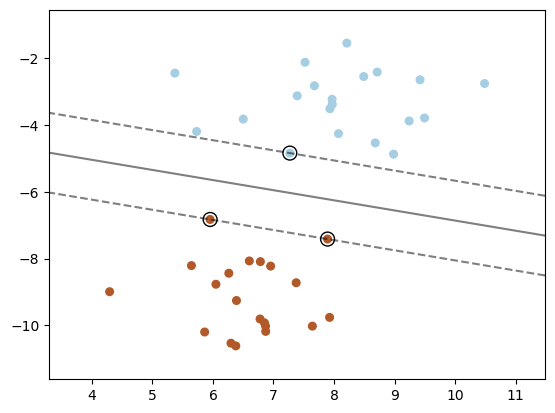

In [2]:
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.datasets import make_blobs
from sklearn.inspection import DecisionBoundaryDisplay as DBD

# 40 separable points
X, y = make_blobs(n_samples=40, centers=2, random_state=6)

# fit the model, don't regularize for illustration purposes
clf = svm.SVC(kernel="linear", C=1000)
clf.fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
DBD.from_estimator(
    clf,
    X,
    plot_method="contour",
    colors="k",
    levels=[-1, 0, 1],
    alpha=0.5,
    linestyles=["--", "-", "--"],
    ax=ax,
)
# plot support vectors
ax.scatter(
    clf.support_vectors_[:, 0],
    clf.support_vectors_[:, 1],
    s=100,
    linewidth=1,
    facecolors="none",
    edgecolors="k",
)
plt.show()

### [Example: binary classification, non-linear (RBF kernel)](https://scikit-learn.org/stable/auto_examples/svm/plot_svm_nonlinear.html#sphx-glr-auto-examples-svm-plot-svm-nonlinear-py)
- Plot the learned decision function. Goal: predict the XOR of the inputs.

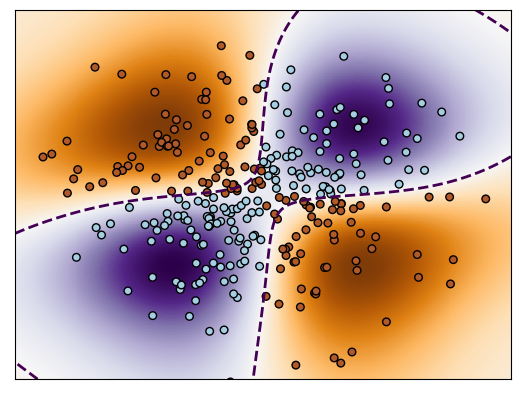

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm

xx, yy = np.meshgrid(np.linspace(-3, 3, 500), np.linspace(-3, 3, 500))
np.random.seed(0)
X = np.random.randn(300, 2)
Y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)

# fit the model
clf = svm.NuSVC(gamma="auto")
clf.fit(X, Y)

# plot the decision function for each datapoint on the grid
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    aspect="auto",
    origin="lower",
    cmap=plt.cm.PuOr_r,
)
contours = plt.contour(xx, yy, Z, levels=[0], linewidths=2, linestyles="dashed")
plt.scatter(X[:, 0], X[:, 1], s=30, c=Y, cmap=plt.cm.Paired, edgecolors="k")
plt.xticks(())
plt.yticks(())
plt.axis([-3, 3, -3, 3])
plt.show()

### [Example: SVM - univariate feature selection](https://scikit-learn.org/stable/auto_examples/svm/plot_svm_anova.html#sphx-glr-auto-examples-svm-plot-svm-anova-py)
- How to do univariate feature selection before running an SVC to improve classification scores.
- Iris dataset (4 features) + 36 non-informative features.
- Expect to find best scores when we select ~10% of the features.

In [4]:
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import chi2
from sklearn.model_selection import cross_val_score as CVS
from sklearn.pipeline import Pipeline as Pipe
from sklearn.preprocessing import StandardScaler as SS
from sklearn.svm import SVC

In [5]:
X, y = load_iris(return_X_y=True)
np.random.seed(0)
# add non-informative features
X = np.hstack((X, 2*np.random.random((X.shape[0], 36))))

In [6]:
# Create a pipeline:
# - feature-selection transform
# - a scaler
# - an instance of SVM
clf = Pipe([('anova', SelectPercentile(chi2)),
            ('scaler', SS()),
            ('svc', SVC(gamma="auto"))])

In [7]:
# plot CV score as function(% of features)
score_means, score_stds = list(), list()
percentiles = (1, 3, 6, 10, 15, 20, 30, 40, 60, 80, 100)

In [8]:
for percentile in percentiles:
    clf.set_params(anova__percentile=percentile)
    this_scores = CVS(clf, X, y)
    score_means.append(this_scores.mean())
    score_stds.append(this_scores.std())

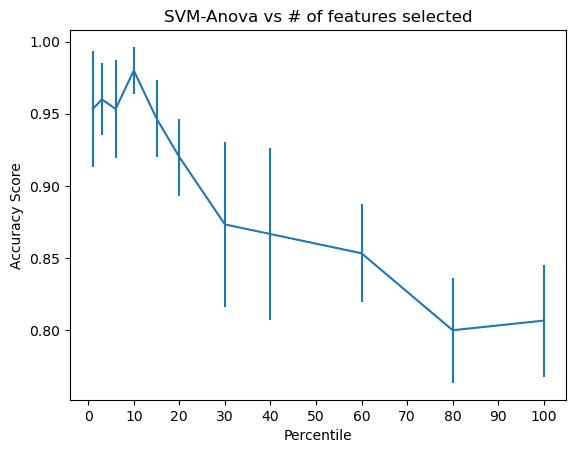

In [14]:
plt.errorbar(percentiles, score_means, np.array(score_stds))
plt.title('SVM-Anova vs # of features selected')
plt.xticks(np.linspace(0, 100, 11, endpoint=True))
plt.xlabel('Percentile')
plt.ylabel('Accuracy Score')
plt.axis('tight')
plt.show()

### [Multiclass classification (SVC, NuSVC)](https://scikit-learn.org/stable/modules/svm.html#multi-class-classification)
- SVC & NuSVC use **one-vs-one** approach.
    - `#classes*(#classes-1)/2` classifiers are built; each trains itself with data from two classes.
    - you can use `decision_function_shape` to transform the results of a OvO classifier into a OvR function of shape `(#samples,#classes)`.
- LinearSVC uses a **one-vs-rest** approach. OvR returns `coef_` (#classes,#features) and `intercept_` (#classes) attributes.

In [11]:
X = [[0], [1], [2], [3]]
Y = [0,    1,   2,   3]

clf = svm.SVC(decision_function_shape='ovo')
clf.fit(X, Y)
dec = clf.decision_function([[1]])
print("decision function (OVO):",dec.shape[1]) # 4 classes: 4*3/2 = 6

clf.decision_function_shape = "ovr"
dec = clf.decision_function([[1]])
print("decision function (OVR)",dec.shape[1]) # 4 classes

lin_clf = svm.LinearSVC()
lin_clf.fit(X, Y)
dec = lin_clf.decision_function([[1]])
print("decision function (Linear SVC)",dec.shape[1])

decision function (OVO): 6
decision function (OVR) 4
decision function (Linear SVC) 4


/home/bjpcjp/.local/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


### [Scoring & Probabilities](https://scikit-learn.org/stable/modules/svm.html#scores-and-probabilities)
- The `decision_function` method returns per-class scoring for each sample.
- If `probability` is `True`, class membership probabilities are enabled.
- Binary classificaton: probabilities are calculated using *Platt scaling* (logistic regression on SVM scoring, fit with an additional cross-validation step.)
- Note: Platt's method known to have theoretical issues. Therefore advisable to set `probability=False` and use `decision_function` instead of `predict_proba`.

### [Unbalanced Classes](https://scikit-learn.org/stable/modules/svm.html#unbalanced-problems)
- Use `class_weight` and `sample_weight` when you need to assign more importance to selected classes.
- **SVC** implements `class_weight` when fitting. It's a dictionary of `{class_label : value}`, where value is a floating point number > 0. It sets the `C` of `class_label` to `C*value`.

### [Example: SVC, unbalanced classes](https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane_unbalanced.html)
- 1) Find the separation plane with a plain vanilla SVC
  2) Plot the hyperplane with auto-correction for unbalanced classes

In [12]:
# we create two clusters of random points
n_samples_1, n_samples_2  = 1000,100
centers      = [[0.0, 0.0], [2.0, 2.0]]
clusters_std =  [1.5,        0.5]

X, y = make_blobs(n_samples=[n_samples_1, n_samples_2],
                  centers=centers,
                  cluster_std=clusters_std,
                  random_state=0, shuffle=False)

In [13]:
clf = svm.SVC(kernel='linear', C=1.0)
wclf = svm.SVC(kernel='linear', class_weight={1: 10})

clf.fit(X,y); wclf.fit(X,y)

SVC(class_weight={1: 10}, kernel='linear')

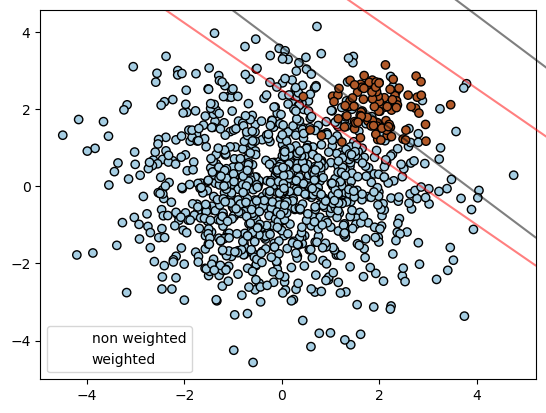

In [14]:
plt.scatter(X[:, 0], 
            X[:, 1], 
            c=y, cmap=plt.cm.Paired, edgecolors='k')

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T

# separating hyperplane
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
a = ax.contour(XX, YY, Z, 
               colors='k', levels=[0], 
               alpha=0.5, linestyles=['-'])

# separating hyperplane - weighted classes
Z = wclf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins (weighted)
b = ax.contour(XX, YY, Z, 
               colors='r', levels=[0], 
               alpha=0.5, linestyles=['-'])

plt.legend([a.collections[0], 
            b.collections[0]], 
           ["non weighted", "weighted"],
           loc="lower left")
plt.show()

### [Weighted Samples](https://scikit-learn.org/stable/auto_examples/svm/plot_weighted_samples.html#sphx-glr-auto-examples-svm-plot-weighted-samples-py)
- SVC/SVR, NuSVC/NuSVR, LinearSVC/SVR, OneClassSVM all support individual sample weights during `fit`ting via the `sample_weight` param.
- It sets `C` for the ith sample to `C*sample_weight[i]`.
- Below: sample weights rescale `C` to emphasize outliers & make the decision boundary deformation very visible.

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm

def plot_decision_function(classifier, sample_weight, axis, title):

    xx, yy = np.meshgrid(np.linspace(-4, 5, 500), 
                         np.linspace(-4, 5, 500))
    Z = classifier.decision_function(np.c_[xx.ravel(), 
                                           yy.ravel()])
    Z = Z.reshape(xx.shape)

    # plot line, points & nearest vectors to the plane
    axis.contourf(xx, yy, Z, 
                  alpha=0.75, cmap=plt.cm.bone)
    axis.scatter(X[:, 0], 
                 X[:, 1], 
                 c=y, s=100*sample_weight, 
                 alpha=0.9,
                 cmap=plt.cm.bone, 
                 edgecolors='black')

    axis.axis('off')
    axis.set_title(title)

In [17]:
# numpy.r_: translate slice objects to concat along 1st axis
print(np.r_[np.array([1,2,3]), 0, 0, np.array([4,5,6])])

print(np.random.randn(10,2))

[1 2 3 0 0 4 5 6]
[[ 0.32114787  0.1790952 ]
 [-1.31038589  1.25854644]
 [ 0.52804914  0.21246181]
 [ 2.04901233  1.61211659]
 [ 0.10682138  0.3023505 ]
 [-0.29444669 -2.44118907]
 [-0.99783516 -0.68601059]
 [-0.8315504   0.52932277]
 [-0.18103081 -0.82291149]
 [ 0.58914159  0.70289484]]


In [18]:
# Create 20 points
np.random.seed(0)
X = np.r_[np.random.randn(10, 2) + [1, 1], 
          np.random.randn(10, 2)]
y = [1]*10 + [-1]*10

sample_weight_last_ten = abs(np.random.randn(len(X)))
sample_weight_constant = np.ones(len(X))
# and bigger weights to some outliers
sample_weight_last_ten[15:] *= 5
sample_weight_last_ten[9]   *= 15

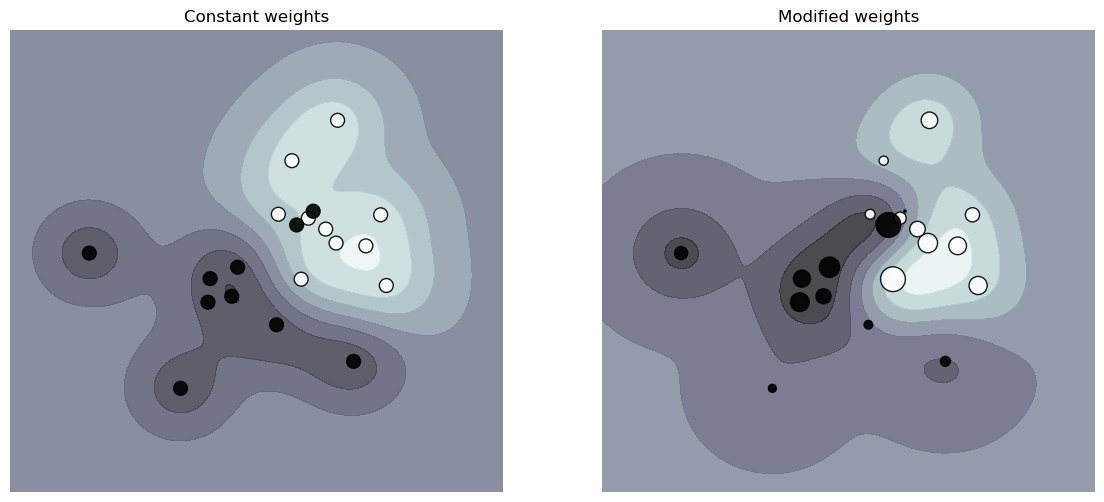

In [19]:
# fit the model
clf_weights = svm.SVC(gamma=1)
clf_weights.fit(X, y, 
                sample_weight=sample_weight_last_ten)

clf_no_weights = svm.SVC(gamma=1)
clf_no_weights.fit(X, y)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_decision_function(clf_no_weights, 
                       sample_weight_constant, 
                       axes[0],
                       "Constant weights")
plot_decision_function(clf_weights, 
                       sample_weight_last_ten, 
                       axes[1],
                       "Modified weights")
plt.show()

### [Support Vector Regression](https://scikit-learn.org/stable/modules/svm.html#regression)
- SVC can be extended to solve regressions.
- SVC needs only a subset of training data (the cost function doesn't care about data outside the margins). SVR similarly ignores samples whose predicted value is close to their target.
- [SVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#sklearn.svm.SVR), [NuSVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.NuSVR.html#sklearn.svm.NuSVR) & [LinearSVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVR.html#sklearn.svm.LinearSVR) implementations supported.
- LinearSVR is faster than SVR, but only supports a linear kernel.
- NuSVR has a slightly different implementation than SVR.

In [20]:
from sklearn import svm
X = [[0, 0], [2, 2]]
y =  [0.5,    2.5]

regr = svm.SVR(); regr.fit(X, y)
print(regr.predict([[1, 1]]))

[1.5]


### [Example: SVR with linear, polynomial & RBF kernels](https://scikit-learn.org/stable/auto_examples/svm/plot_svm_regression.html#sphx-glr-auto-examples-svm-plot-svm-regression-py)
- Using a toy 1D dataset

In [21]:
from sklearn.svm import SVR

X = np.sort(5 * np.random.rand(40, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - np.random.rand(8)) #noise

In [22]:
svr_rbf  = SVR(kernel='rbf',    C=100, gamma=0.1, epsilon=.1)
svr_lin  = SVR(kernel='linear', C=100, gamma='auto')
svr_poly = SVR(kernel='poly',   C=100, gamma='auto', 
               degree=3, epsilon=.1, coef0=1)

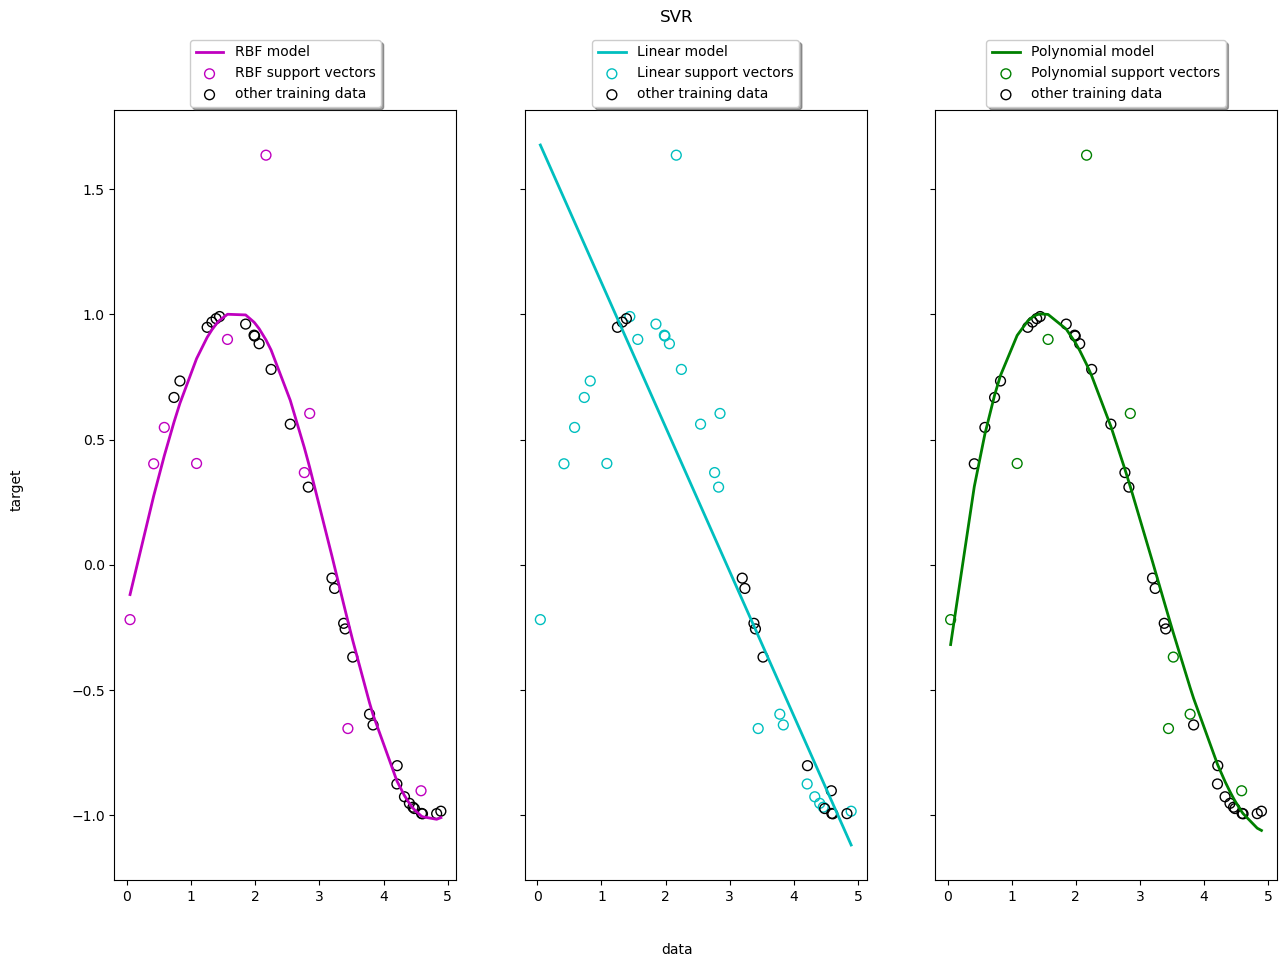

In [23]:
svrs         = [svr_rbf, svr_lin, svr_poly]
kernel_label = ['RBF', 'Linear', 'Polynomial']
model_color  = ['m', 'c', 'g']

fig, axes = plt.subplots(nrows=1, ncols=3, 
                         figsize=(15, 10), sharey=True)

for ix, svr in enumerate(svrs):
    axes[ix].plot(X, 
                  svr.fit(X, y).predict(X), 
                  color=model_color[ix], lw=2,
                  label='{} model'.format(kernel_label[ix]))
    
    axes[ix].scatter(X[svr.support_], 
                     y[svr.support_], 
                     facecolor="none",
                     edgecolor=model_color[ix], s=50,
                     label='{} support vectors'.format(kernel_label[ix]))

    axes[ix].scatter(X[np.setdiff1d(np.arange(len(X)), svr.support_)],
                     y[np.setdiff1d(np.arange(len(X)), svr.support_)],
                     facecolor="none", 
                     edgecolor="k", s=50,
                     label='other training data')
    
    axes[ix].legend(loc='upper center', 
                    bbox_to_anchor=(0.5, 1.1),
                    ncol=1, fancybox=True, shadow=True)

fig.text(0.5, 0.04, 'data',   ha='center', va='center')
fig.text(0.06, 0.5, 'target', ha='center', va='center', rotation='vertical')
fig.suptitle("SVR"); plt.show()

### [Computation Complexity & Best Practices](https://scikit-learn.org/stable/modules/svm.html#complexity)
- SVM is a *quadratic problem*. The [libsvm](https://www.csie.ntu.edu.tw/~cjlin/libsvm/) QP solver scales between $O(n_{features} \times n_{samples}^2)$ and $O(n_{features} \times n_{samples}^3)$ depending on libsvm's data cache. 
- The [liblinear](https://www.csie.ntu.edu.tw/~cjlin/liblinear/) solver used by LinearSVC is much more efficient and scales almost linearly to very large datasets.
- Tips:
    - Several methods will be *copied* before being used by the underlying algorithm if they are not __C-ordered contiguous & double precision__. (Check this using the `flags` attribute.)
    - __Kernel cache size__ has a large impact on performance. Set `cache_size` higher than the default (200MB), if memory allows.
    - `C` is set to 1.0 by default. If you have a noisy dataset, smaller values of C leads to more regularization.
    - Larger values of `C` consume more training time, sometimes 10X. Also, LinearSVR & LinearSVC are less sensitive to `C` as it increases.
    - **Scale your data to [0,1], [-1,+1], or standardize it to mean=0 variance=1.** SVM algorithms are not scale-invariant. Pipelines are a convenient way to do this.

In [27]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
clf = make_pipeline(StandardScaler(), SVC())

### [Kernel function options](https://scikit-learn.org/stable/modules/svm.html#kernel-functions)
- Also: see [Kernel approximation](https://scikit-learn.org/stable/modules/kernel_approximation.html#kernel-approximation) if you need a faster / more scalable RBF kernel.
- linear: $\langle x, x'\rangle$
- polynomial: $(\gamma \langle x, x'\rangle + r)^d$
    - $d$ is specified by `degree`; $r$ specified by `coef0`.
- RBF: $\exp(-\gamma \|x-x'\|^2)$
    - $\gamma$ is specified by `gamma`>0.
- sigmoid: $\tanh(\gamma \langle x,x'\rangle + r)$
    - $r$ specified by `coef0`.

In [24]:
linear_svc = svm.SVC(kernel='linear'); print(linear_svc.kernel)
rbf_svc = svm.SVC(kernel='rbf');       print(rbf_svc.kernel)

linear
rbf


### [RBF kernel parameters: `C` and `gamma`](https://scikit-learn.org/stable/modules/svm.html#parameters-of-the-rbf-kernel)
- `C` trades misclassifications against decision surface simplicity.
    - low `C` smooths the decision surface
    - high `C` strives to correctly classify all samples.
- `gamma` sets an influence weight for each training sample.
    - larger `gamma` requires other samples to be closer to be affected
- Use [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV), with `C` and `gamma` spaced exponentially, to find correct values of each.

### [example: SVM params w/ RBF kernel](https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html#sphx-glr-auto-examples-svm-plot-rbf-parameters-py)
- `gamma` defines the 'reach' (influence) of a single training example (low values = ‘far’; high values = ‘close’).

- `C` trades correct classifications against maximization of the decision function’s margin. A lower C will encourage a larger margin, therefore a simpler decision function, at the cost of training accuracy. In other words `C` behaves as a regularization parameter.

- Plot #1: a visualization of the decision function for a variety of parameter values on a simple classification (2 input features, 2 possible target classes). This type of plot is not possible for problems with more features or target classes.

- Plot #2: a heatmap of __cross-validation accuracy__ vs `C` and `gamma`. We use a large grid for illustration. In practice, a logarithmic grid from 10^-3 to 10^+3 is usually enough. If the best parameters lie on the boundaries of the grid, it can be extended in that direction in a subsequent search.

- The heat map includes a colorbar with a midpoint value close to the score values of the best performing models. This makes it easy to tell them apart.

- The model is __very sensitive to `gamma`__.
    - If `gamma` is too large, the radius of the area of influence of the support vectors only includes the support vector itself - no amount of regularization with `C` will prevent overfitting.
    - When `gamma` is too small, the model is constrained & can't capture the complexity or “shape” of the data. The region of influence of any selected support vector would include the whole training set. The resulting model will behave similarly to a linear model with a set of hyperplanes that separate the centers of high density of any pair of two classes.

- The 2nd plot shows that good models can be found on a diagonal of C and gamma. Smooth models (lower gamma values) can be made more complex by increasing the importance of classifying each point correctly (larger C values) hence the diagonal of good performing models.

- For some intermediate values of `gamma` we get equally performing models when `C` becomes very large. This suggests that the set of support vectors does not change anymore. The radius of the RBF kernel alone acts as a good structural regularizer. Increasing C further doesn’t help, likely because there are no more training points in violation (inside the margin or wrongly classified), or at least no better solution can be found.

- Scores being equal, it may make sense to use the smaller `C` values, since very high `C` values typically increase fitting time.

- Lower `C` values generally lead to more support vectors, which may increase prediction time. Therefore, lowering the value of `C` involves a trade-off between fitting time and prediction time.

- Small differences in scores results from random splits of the cross-validation procedure. Those spurious variations can be smoothed out by increasing the number of CV iterations `n_splits` at the expense of compute time. Increasing the value number of `C_range` and `gamma_range steps will increase the resolution of the hyper-parameter heat map.

In [34]:
from matplotlib.colors import Normalize
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

In [35]:
# Utility function to move the midpoint of a colormap to be around
# the values of interest.

class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, 
                 clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [36]:
iris = load_iris()
X,y = iris.data, iris.target

In [37]:
# Dataset for decision function viz - only keep the first two
# features in X, sub-sample the dataset to keep only 2 classes and
# make it a binary classification problem.

X_2d = X[:, :2]
X_2d = X_2d[y > 0]
y_2d = y[y > 0]
y_2d -= 1

In [38]:
scaler = StandardScaler()
X      = scaler.fit_transform(X)
X_2d   = scaler.fit_transform(X_2d)

In [39]:
# Train classifiers
C_range     = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid  = dict(gamma=gamma_range, C=C_range)

cv   = StratifiedShuffleSplit(n_splits=5, 
                              test_size=0.2, 
                              random_state=42)
grid = GridSearchCV(SVC(), 
                    param_grid=param_grid, 
                    cv=cv)
grid.fit(X, y)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.2,
            train_size=None),
             estimator=SVC(),
             param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10]),
                         'gamma': array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
       1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])})

In [40]:
# Fit a classifier for all params in the 2d version
# Use a smaller set of params - training time

C_2d_range     = [1e-2, 1, 1e2]
gamma_2d_range = [1e-1, 1, 1e1]
classifiers    = []

for C in C_2d_range:
    for gamma in gamma_2d_range:
        clf = SVC(C=C, gamma=gamma)
        clf.fit(X_2d, y_2d)
        classifiers.append((C, gamma, clf))

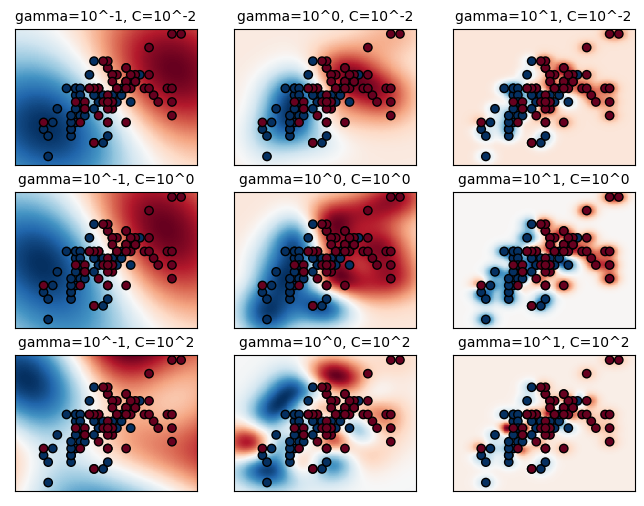

In [41]:
# Viz of param effect

plt.figure(figsize=(8, 6))

xx, yy = np.meshgrid(np.linspace(-3, 3, 200), 
                     np.linspace(-3, 3, 200))

for (k, (C, gamma, clf)) in enumerate(classifiers):
    # evaluate decision function in a grid
    Z = clf.decision_function(np.c_[xx.ravel(), 
                                    yy.ravel()])
    Z = Z.reshape(xx.shape)

    # visualize decision function
    plt.subplot(len(C_2d_range), 
                len(gamma_2d_range), 
                k + 1)
    
    plt.title("gamma=10^%d, C=10^%d" % (np.log10(gamma), 
                                        np.log10(C)),
              size='medium')

    # visualize parameter's effect on decision function
    plt.pcolormesh(xx, yy, -Z, 
                   cmap=plt.cm.RdBu)

    plt.scatter(X_2d[:, 0], 
                X_2d[:, 1], 
                c=y_2d, cmap=plt.cm.RdBu_r,
                edgecolors='k')
    
    plt.xticks(()); plt.yticks(()); plt.axis('tight')

scores = grid.cv_results_['mean_test_score'].reshape(len(C_range),
                                                     len(gamma_range))

- Heatmap: validation accuracy vs `gamma` and `C`
- Scoring is dark red to bright yellow.
- Use custom normalizer to set midpoint to 0.92 for easier viewing.

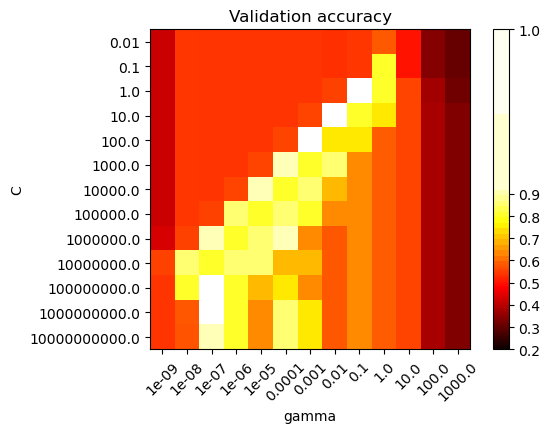

In [42]:
plt.figure(figsize=(6, 4))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, 
           interpolation='nearest', 
           cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))

plt.xlabel('gamma'); plt.ylabel('C'); plt.colorbar()

plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)),     C_range)
plt.title('Validation accuracy')
plt.show()

### [Custom SVM kernels](https://scikit-learn.org/stable/modules/svm.html#custom-kernels)
- Define custom kernels using a Python function, or by precomputing a **[Gram matrix](https://en.wikipedia.org/wiki/Gram_matrix)**.
    - Pass the function to the `kernel` parameter. The kernel must input two matrices `(#samples1, #features)` & `(#samples2, #features)`, and return a kernel matrix of `(#samples1, #samples2)`.

In [55]:
# custom kernel - python function
import numpy as np
from sklearn import svm
def my_kernel(X, Y):
    return np.dot(X, Y.T)
clf = svm.SVC(kernel=my_kernel)

### [example: SVM with custom kernel](https://scikit-learn.org/stable/auto_examples/svm/plot_custom_kernel.html#sphx-glr-auto-examples-svm-plot-custom-kernel-py)
- classifies Iris dataset, plots decision surface & support vectors.

In [56]:
from sklearn import svm,datasets
iris = datasets.load_iris()
X,Y = iris.data[:,:2], iris.target # only use 1st two features

In [57]:
h = 0.02 # mesh step size
clf = svm.SVC(kernel=mykernel); clf.fit(X,Y)

SVC(kernel=<function mykernel at 0x7fbca64f9300>)

In [58]:
# plot decision boundary. assign color to each point in mesh
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), 
                     np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), 
                      yy.ravel()])

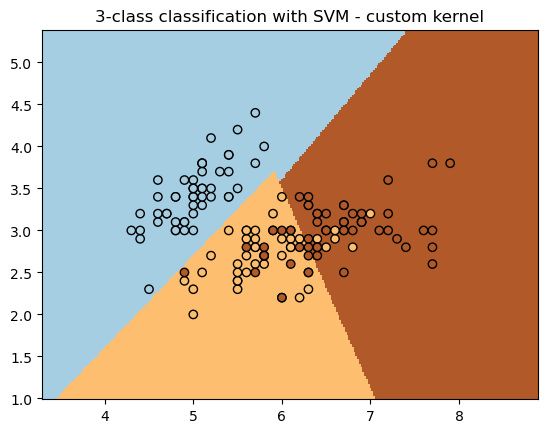

In [59]:
Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

plt.scatter(X[:, 0], 
            X[:, 1], 
            c=Y, cmap=plt.cm.Paired, edgecolors='k')
plt.title('3-class classification with SVM - custom kernel')
plt.axis('tight'); plt.show()


### Precomputed kernels via the Gram Matrix
- Use the `kernel='precomputed'` option.

In [60]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn import svm

X, y = make_classification(n_samples=10, random_state=0)

X_train , X_test , y_train, y_test = train_test_split(X, y, 
                                                      random_state=0)
clf = svm.SVC(kernel='precomputed')
# linear kernel computation
gram_train = np.dot(X_train, X_train.T)
clf.fit(gram_train, y_train)

# predict on training examples
gram_test = np.dot(X_test, X_train.T)
clf.predict(gram_test)

array([0, 1, 0])